In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

In [2]:
DATA = Path("../data/raw")
train = pd.read_csv(DATA / "train.csv", parse_dates=["Date"])
store = pd.read_csv(DATA / "store.csv")

C:\Users\varun\AppData\Local\Temp\ipykernel_1032\1635115470.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(DATA / "train.csv", parse_dates=["Date"])


In [3]:
print("train shape:", train.shape)
print("store shape:", store.shape)
display(train.head(3))
display(store.head(3))

train shape: (1017209, 9)
store shape: (1115, 10)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


In [4]:
# Basic sanity checks
assert {"Store","Date","Sales","Open"}.issubset(train.columns)
assert {"Store","StoreType","Assortment"}.issubset(store.columns)

In [5]:
#Merging train and store
df = train.merge(store, on="Store", how="left")

In [6]:
# Quick null/closed-day snapshot (ie % of missing values in the columns)
nulls = df.isna().mean().sort_values(ascending=False).head(10)
closed_pct = (df["Open"]==0).mean()
print("Top-10 null %:\n", nulls)
print("Pct days store closed:", round(closed_pct, 3))

Top-10 null %:
 PromoInterval                0.499436
Promo2SinceYear              0.499436
Promo2SinceWeek              0.499436
CompetitionOpenSinceYear     0.317878
CompetitionOpenSinceMonth    0.317878
CompetitionDistance          0.002597
DayOfWeek                    0.000000
Promo2                       0.000000
Assortment                   0.000000
Store                        0.000000
dtype: float64
Pct days store closed: 0.17


In [7]:
# Pick one store for first visual checks
one_store = df[df["Store"]==1].sort_values("Date")
one_store = one_store[one_store["Open"]==1]  # ignore closed days for sales patterns

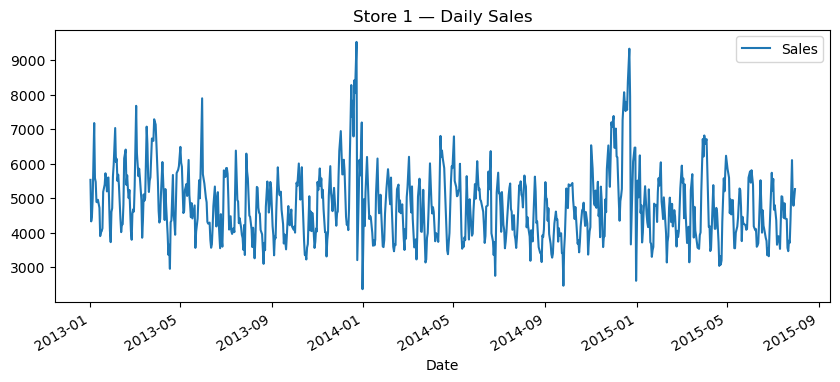

In [8]:
# Minimal daily plot
import matplotlib.pyplot as plt
one_store.plot(x="Date", y="Sales", figsize=(10,4), title="Store 1 — Daily Sales")
plt.show()

In [9]:
# Sort rows to make time operations predictable
df = df.sort_values(["Store", "Date"]).reset_index(drop=True)

In [10]:
# Quick record counts (baseline)
n_total = len(df)
n_closed = (df["Open"] == 0).sum()
n_zero_sales = ((df["Open"] == 1) & (df["Sales"] == 0)).sum()
print({"total_rows": n_total, "closed_days": int(n_closed), "open_zero_sales": int(n_zero_sales)})

{'total_rows': 1017209, 'closed_days': 172817, 'open_zero_sales': 54}


In [11]:
df_open = df[df["Open"] == 1].copy()
df_train = df_open[df_open["Sales"] > 0].copy()  # recommended for modeling
print("After filtering -> df_open:", df_open.shape, "| df_train (Open & Sales>0):", df_train.shape)

After filtering -> df_open: (844392, 18) | df_train (Open & Sales>0): (844338, 18)


Now handling missing data

CompetitionDistance will strongly correlates with sales. we don’t want to drop rows just because this is missing. Median-by-StoreType is a safe imputation.
First use median distance within the same store type. If still missing, fall back to overall median

In [12]:
dist = df_train["CompetitionDistance"]
if dist.isna().any():
    df_train["CompetitionDistance"] = df_train.groupby("StoreType")["CompetitionDistance"] \
        .transform(lambda s: s.fillna(s.median()))
    df_train["CompetitionDistance"] = df_train["CompetitionDistance"].fillna(df_train["CompetitionDistance"].median())

Open-since and promo-since fields: NA means "no competition/promo info"

In [13]:
for col in ["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear", "Promo2SinceWeek", "Promo2SinceYear"]:
    if col in df_train.columns:
        df_train[col] = df_train[col].fillna(0).astype(int)

PromoInterval: NA -> 'None'

In [14]:
if "PromoInterval" in df_train.columns:
    df_train["PromoInterval"] = df_train["PromoInterval"].fillna("None")

Categorical typing for memory/perf clarity

In [15]:
cat_cols = ["StoreType", "Assortment", "PromoInterval", "StateHoliday"]
for c in cat_cols:
    if c in df_train.columns:
        df_train[c] = df_train[c].astype("category")

Now let's vizualize per-store daily series and weekly-smoothed version

In [16]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [17]:
store_id = 1  # we can change this to explore other stores, for now let's do store 1
s = df_train[df_train["Store"] == store_id].copy()

In [18]:
# Keep only relevant columns for clarity
s = s[["Date", "Sales", "Promo", "SchoolHoliday", "StateHoliday"]].sort_values("Date")

In [19]:
# Set time index for resampling and decomposition-friendly operations
s = s.set_index("Date")

In [20]:
# Create a weekly series to smooth noise and regularize frequency
weekly_sales = s["Sales"].resample("W").mean()

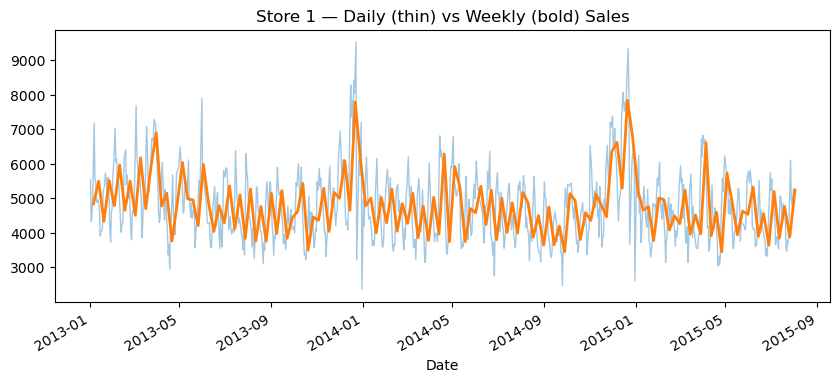

In [21]:
# Plot daily vs weekly for a quick visual sanity check
ax = s["Sales"].plot(figsize=(10, 4), alpha=0.4, lw=1, title=f"Store {store_id} — Daily (thin) vs Weekly (bold) Sales")
weekly_sales.plot(ax=ax, lw=2)
plt.show()

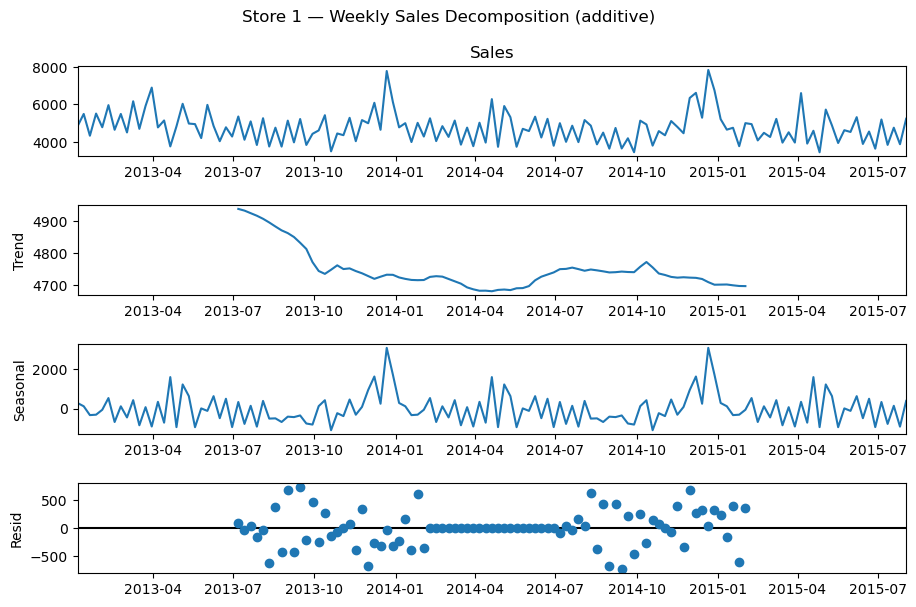

In [22]:
# Seasonal decomposition (weekly data, additive model, yearly-ish seasonality ~52 weeks)
decomp = seasonal_decompose(weekly_sales.dropna(), model="additive", period=52)
fig = decomp.plot()
fig.set_size_inches(10, 6)
plt.suptitle(f"Store {store_id} — Weekly Sales Decomposition (additive)", y=1.02)
plt.show()

We do ADF for stationarity since our sales trend is non-stationary

In [23]:
from statsmodels.tsa.stattools import adfuller

In [24]:
series = weekly_sales.dropna() #reusing store 1 weekly sales

In [25]:
result = adfuller(series)

output = {
    "adf_statistic": result[0],
    "p_value": result[1],
    "used_lags": result[2],
    "n_obs": result[3]
}
print(output)

{'adf_statistic': -3.7579882338558184, 'p_value': 0.003367614361969351, 'used_lags': 3, 'n_obs': 131}


In [26]:
# Critical values for reference
for key, val in result[4].items():
    print(f"Critical Value ({key}): {val:.3f}")

Critical Value (1%): -3.481
Critical Value (5%): -2.884
Critical Value (10%): -2.579


p_value < 0.05 and adf_statistic < critical value (5%) so we confirm stationarity here and we model directly

Now we perform some outlier capping on per-store basis using log + IQR

In [27]:
'''def cap_outliers_per_store(frame, value_col="Sales", group_col="Store", log_eps=1.0):
    capped_groups = []
    for _, sub in frame.groupby(group_col):
        # 1. Log transform (stabilizes variance, makes extreme spikes easier to detect)
        x = np.log(sub[value_col] + log_eps)

        # 2. Calculate interquartile range (IQR)
        q1, q3 = x.quantile(0.25), x.quantile(0.75)
        iqr = q3 - q1

        # 3. Define bounds (3*IQR = conservative cap)
        lo, hi = q1 - 3*iqr, q3 + 3*iqr

        # 4. Clip values outside bounds
        x_capped = x.clip(lo, hi)

        # 5. Transform back to original scale
        sub[value_col] = np.exp(x_capped) - log_eps
        capped_groups.append(sub)

    return pd.concat(capped_groups, axis=0)

df_train = cap_outliers_per_store(df_train, "Sales", "Store", log_eps=1.0)'''

'def cap_outliers_per_store(frame, value_col="Sales", group_col="Store", log_eps=1.0):\n    capped_groups = []\n    for _, sub in frame.groupby(group_col):\n        # 1. Log transform (stabilizes variance, makes extreme spikes easier to detect)\n        x = np.log(sub[value_col] + log_eps)\n\n        # 2. Calculate interquartile range (IQR)\n        q1, q3 = x.quantile(0.25), x.quantile(0.75)\n        iqr = q3 - q1\n\n        # 3. Define bounds (3*IQR = conservative cap)\n        lo, hi = q1 - 3*iqr, q3 + 3*iqr\n\n        # 4. Clip values outside bounds\n        x_capped = x.clip(lo, hi)\n\n        # 5. Transform back to original scale\n        sub[value_col] = np.exp(x_capped) - log_eps\n        capped_groups.append(sub)\n\n    return pd.concat(capped_groups, axis=0)\n\ndf_train = cap_outliers_per_store(df_train, "Sales", "Store", log_eps=1.0)'

Now, we'll add new calendar features from the dates into model friendly features

In [28]:
df_train = df_train.sort_values(["Store","Date"]).copy()

df_train["Year"] = df_train["Date"].dt.year
df_train["Month"] = df_train["Date"].dt.month
df_train["Week"] = df_train["Date"].dt.isocalendar().week.astype(int)
df_train["DayOfWeek"] = df_train["Date"].dt.dayofweek  # 0=Mon ... 6=Sun
df_train["IsWeekend"] = df_train["DayOfWeek"].isin([5,6]).astype(int)

df_train["MonthName"] = df_train["Date"].dt.month_name()
df_train["Quarter"] = df_train["Date"].dt.quarter

df_train[["Date","Year","Month","Week","DayOfWeek","IsWeekend"]].head()

,Date,Year,Month,Week,DayOfWeek,IsWeekend
1,2013-01-02,2013,1,1,2,0
2,2013-01-03,2013,1,1,3,0
3,2013-01-04,2013,1,1,4,0
4,2013-01-05,2013,1,1,5,1
6,2013-01-07,2013,1,2,0,0


Now, some per-store summary

In [29]:
store_summary = (
    df_train
    .groupby("Store")
    .agg(
        mean_sales=("Sales","mean"),
        median_sales=("Sales","median"),
        promo_rate=("Promo","mean"),
        n_days=("Sales","size")
    )
    .sort_values("mean_sales", ascending=False)
)

print("Top 5 stores by mean sales:")
display(store_summary.head(5))
print("\nBottom 5 stores by mean sales:")
display(store_summary.tail(5))

Top 5 stores by mean sales:


,mean_sales,median_sales,promo_rate,n_days
Store,,,,
817,21757.483418,21872.0,0.450255,784
262,20718.515924,19415.5,0.382166,942
1114,20666.562500,20412.5,0.450255,784
251,19123.068036,18566.0,0.449294,779
842,18574.795820,18330.0,0.440514,622



Bottom 5 stores by mean sales:


,mean_sales,median_sales,promo_rate,n_days
Store,,,,
841,2972.608974,2907.0,0.451282,780
208,2936.290816,2927.5,0.450255,784
198,2900.604859,2526.0,0.451407,782
543,2790.380282,2293.0,0.448143,781
307,2703.736573,2602.5,0.451407,782


Promo vs non promo comparison

In [30]:
'''promo_cmp = (
    df_train
    .groupby(["Store","DayOfWeek","Promo"])["Sales"]
    .mean()
    .unstack("Promo")
    .rename(columns={0:"no_promo",1:"promo"})
    .dropna()
)
promo_cmp["uplift_abs"] = promo_cmp["promo"] - promo_cmp["no_promo"]
promo_cmp["uplift_pct"] = promo_cmp["uplift_abs"] / promo_cmp["no_promo"]

# Aggregate across stores/days to see overall effect distribution
uplift_overall = promo_cmp["uplift_pct"].describe(percentiles=[.25,.5,.75])
uplift_overall'''

count    5575.000000
mean        0.397799
std         0.187942
min        -0.039625
25%         0.267587
50%         0.365145
75%         0.487133
max         1.834581
Name: uplift_pct, dtype: float64

Holiday impact on sales

In [31]:
# SchoolHoliday
sch = (
    df_train.groupby(["Store","DayOfWeek","SchoolHoliday"])["Sales"]
    .mean().unstack("SchoolHoliday").rename(columns={0:"no_school_holiday",1:"school_holiday"})
)
sch["school_uplift_pct"] = (sch["school_holiday"] - sch["no_school_holiday"]) / sch["no_school_holiday"]

# StateHoliday (values can be '0','a','b','c')
state_mean = df_train.groupby("StateHoliday")["Sales"].mean().sort_values(ascending=False)
sch["school_uplift_pct"].describe(), state_mean

(count    5713.000000
 mean        0.003772
 std         0.074906
 min        -0.184536
 25%        -0.044775
 50%        -0.002993
 75%         0.040493
 max         0.546266
 Name: school_uplift_pct, dtype: float64,
 StateHoliday
 b    9887.889655
 c    9743.746479
 a    8487.471182
 0    6992.483936
 0    6702.687531
 Name: Sales, dtype: float64)

Now we do a distribution check to see if we need to transform

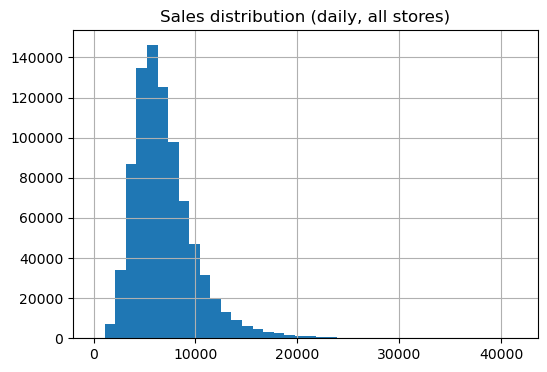

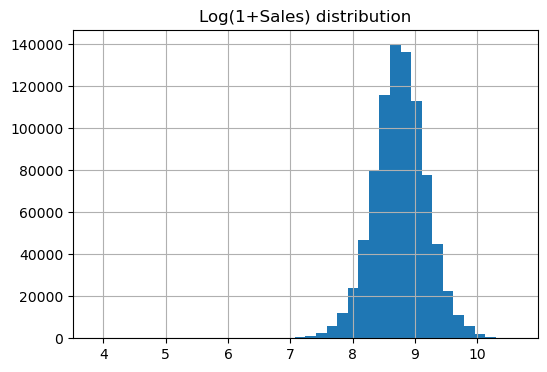

Corr(Sales, Customers) = 0.824


In [32]:
fig, ax = plt.subplots(figsize=(6,4))
df_train["Sales"].hist(bins=40, ax=ax)
ax.set_title("Sales distribution (daily, all stores)")
plt.show()

# Optional: log distribution (stabilizes variance)
fig, ax = plt.subplots(figsize=(6,4))
np.log1p(df_train["Sales"]).hist(bins=40, ax=ax)
ax.set_title("Log(1+Sales) distribution")
plt.show()

# If Customers column exists, check correlation with Sales
if "Customers" in df_train.columns:
    corr = df_train[["Sales","Customers"]].corr().iloc[0,1]
    print("Corr(Sales, Customers) =", round(corr,3))

We'll do a temporal split that we'll use later

In [33]:
cutoff_date = df_train["Date"].max() - pd.Timedelta(weeks=6)

train_mask = df_train["Date"] <= cutoff_date
valid_mask = df_train["Date"] > cutoff_date

print("Cutoff date:", cutoff_date.date())
print("Train rows:", train_mask.sum(), "| Valid rows:", valid_mask.sum())

Cutoff date: 2015-06-19
Train rows: 804056 | Valid rows: 40282


We'll now build a baseline ARIMA model for Store 1 weekly sales

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  135
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1096.523
Date:                Mon, 08 Sep 2025   AIC                           2201.046
Time:                        15:19:45   BIC                           2212.667
Sample:                    01-06-2013   HQIC                          2205.768
                         - 08-02-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4777.7768     86.360     55.324      0.000    4608.514    4947.040
ar.L1         -0.8457      0.166     -5.087      0.000      -1.171      -0.520
ma.L1          0.7174      0.217      3.313      0.0

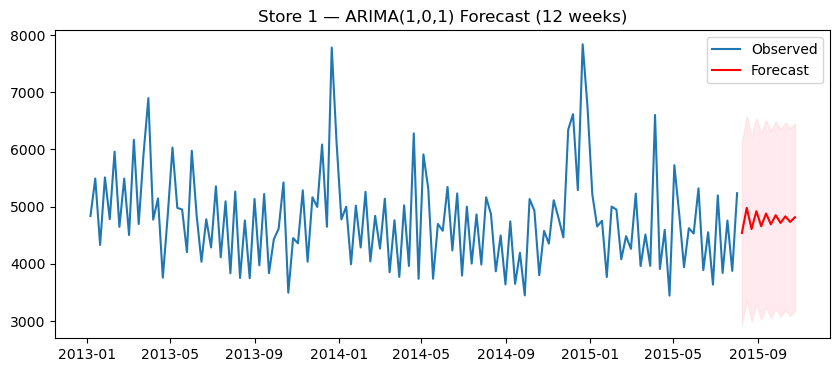

In [34]:
from statsmodels.tsa.arima.model import ARIMA

series = weekly_sales.dropna()

# Define and fit ARIMA model
# (p=1, d=0, q=1) chosen as a simple starting point
model = ARIMA(series, order=(1,0,1))
model_fit = model.fit()

print(model_fit.summary())

# Forecast next 12 weeks
forecast = model_fit.get_forecast(steps=12)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot actual + forecast
plt.figure(figsize=(10,4))
plt.plot(series.index, series, label="Observed")
plt.plot(mean_forecast.index, mean_forecast, label="Forecast", color="red")
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], 
                 color="pink", alpha=0.3)
plt.title("Store 1 — ARIMA(1,0,1) Forecast (12 weeks)")
plt.legend()
plt.show()

Now, extendidng this with SARIMA

C:\Users\varun\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  135
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 52)   Log Likelihood                -222.486
Date:                            Mon, 08 Sep 2025   AIC                            454.973
Time:                                    15:40:46   BIC                            461.809
Sample:                                01-06-2013   HQIC                           457.114
                                     - 08-02-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0865      0.628      0.138      0.890      -1.145       1.318
ma.L1         -0.3714      0.618   

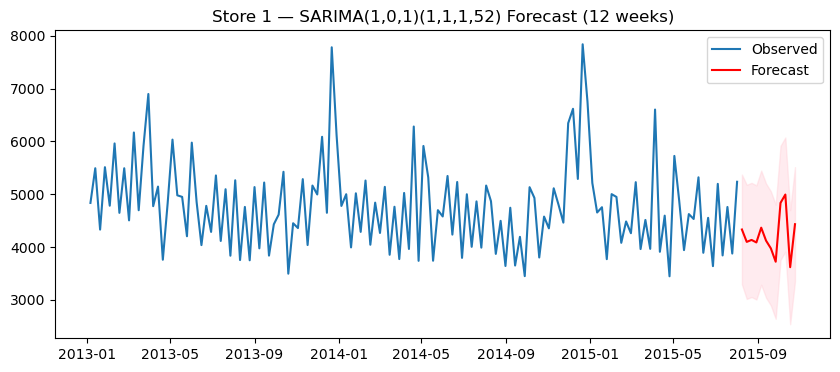

In [35]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

series = weekly_sales.dropna()

# Non-seasonal order = (1,0,1) from before
# Seasonal order = (1,1,1,52) -> yearly seasonality with differencing
model = SARIMAX(series,
                order=(1,0,1),
                seasonal_order=(1,1,1,52),
                enforce_stationarity=False,
                enforce_invertibility=False)

sarima_fit = model.fit(disp=False)
print(sarima_fit.summary())

# Forecast next 12 weeks
forecast = sarima_fit.get_forecast(steps=12)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

plt.figure(figsize=(10,4))
plt.plot(series.index, series, label="Observed")
plt.plot(mean_forecast.index, mean_forecast, label="Forecast", color="red")
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1],
                 color="pink", alpha=0.3)
plt.title("Store 1 — SARIMA(1,0,1)(1,1,1,52) Forecast (12 weeks)")
plt.legend()
plt.show()

Now trying Prophet

16:49:14 - cmdstanpy - INFO - Chain [1] start processing
16:49:14 - cmdstanpy - INFO - Chain [1] done processing


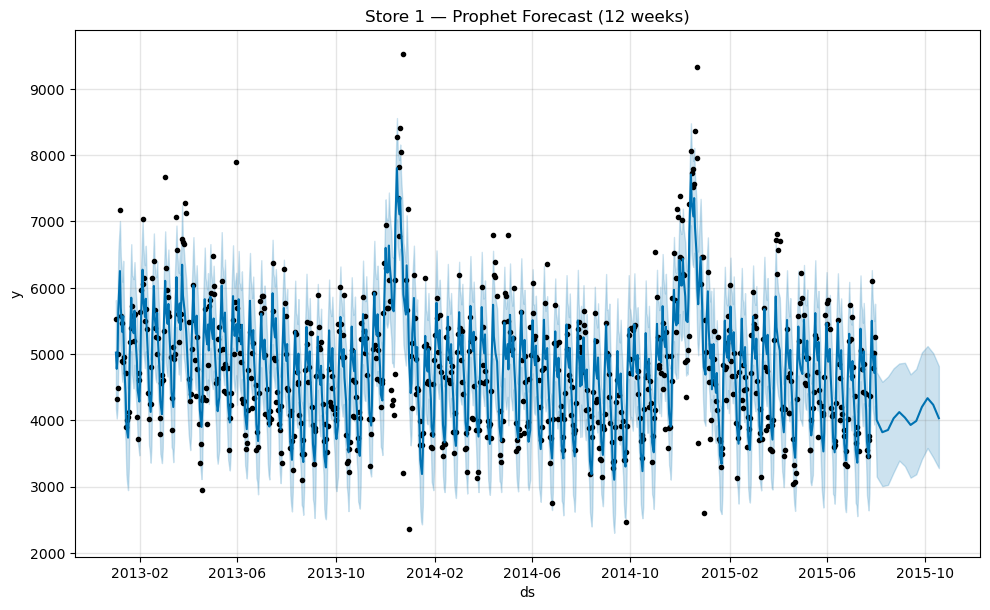

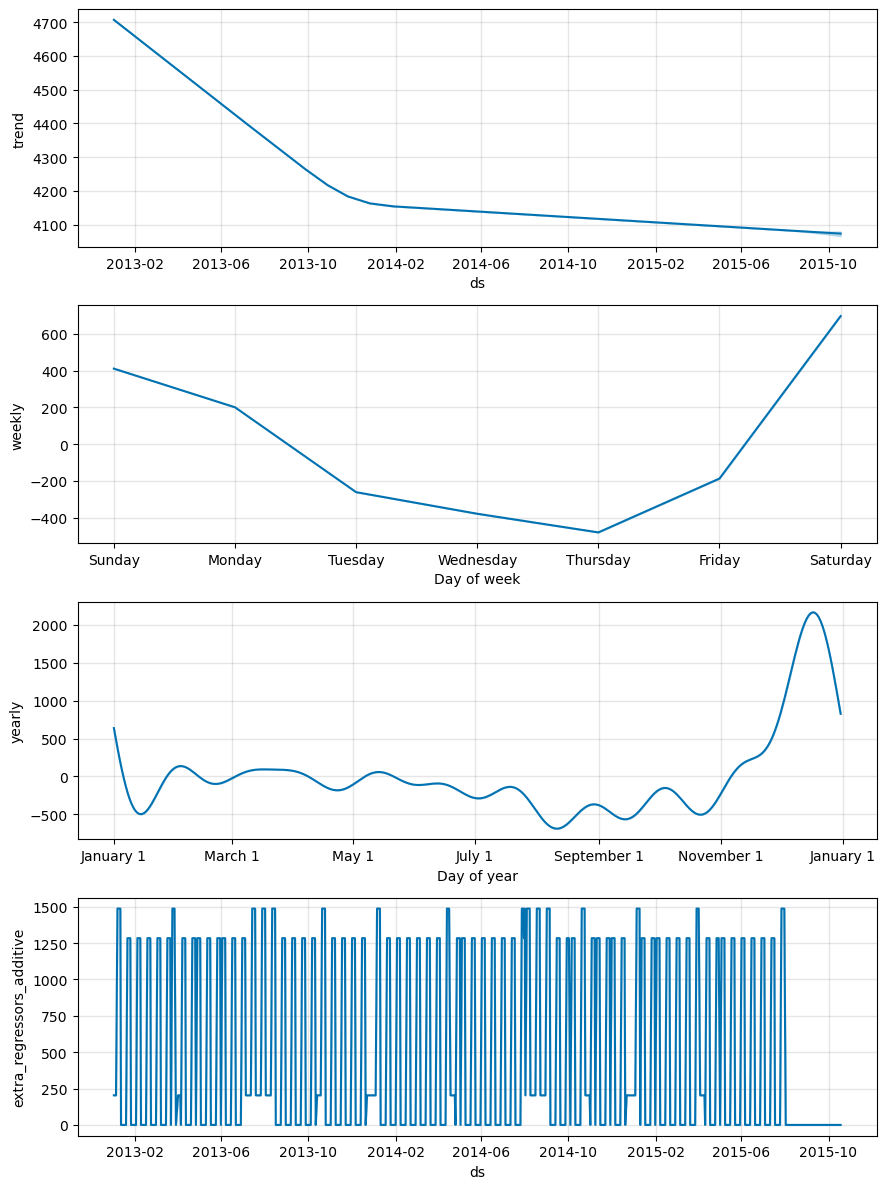

In [36]:
from prophet import Prophet

# Prophet expects columns: ds (date), y (target)
s = df_train[df_train["Store"] == 1].copy()
s = s[["Date","Sales","Promo","SchoolHoliday"]].sort_values("Date")
s.rename(columns={"Date":"ds","Sales":"y"}, inplace=True)

m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

# Add extra regressors
m.add_regressor("Promo")
m.add_regressor("SchoolHoliday")

m.fit(s)

# Create future dataframe: next 12 weeks
future = m.make_future_dataframe(periods=12, freq="W")

# Merge in regressors for the forecast horizon
# For simplicity assume no promos and no school holidays in the next 12 weeks
future = future.merge(s[["ds","Promo","SchoolHoliday"]], on="ds", how="left")
future["Promo"].fillna(0, inplace=True)
future["SchoolHoliday"].fillna(0, inplace=True)

forecast = m.predict(future)

fig1 = m.plot(forecast)
plt.title("Store 1 — Prophet Forecast (12 weeks)")
plt.show()

# Plot components (trend, yearly, weekly, regressors)
fig2 = m.plot_components(forecast)
plt.show()

Now let's compare the models

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Helper metric functions
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(((y_true - y_pred) / y_true) ** 2)) * 100

def evaluate_model(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    rmpse = rmspe(y_true, y_pred)
    print(f"{name} -> RMSE: {rmse:.1f}, MAE: {mae:.1f}, MAPE: {mape:.2f}%, RMSPE: {rmpse:.2f}%")
    return {"RMSE":rmse,"MAE":mae,"MAPE":mape,"RMSPE":rmpse}

# Split train/valid for Store 1 weekly series
series = weekly_sales.dropna()
cutoff_date = series.index.max() - pd.Timedelta(weeks=6)
train_series = series[series.index <= cutoff_date]
valid_series = series[series.index > cutoff_date]

# ARIMA(1,0,1)
arima = ARIMA(train_series, order=(1,0,1)).fit()
arima_forecast = arima.forecast(steps=len(valid_series))
arima_results = evaluate_model(valid_series, arima_forecast, "ARIMA(1,0,1)")

# SARIMA(1,0,1)(1,1,1,52)
sarima = SARIMAX(train_series, order=(1,0,1), seasonal_order=(1,1,1,52),
                 enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
sarima_forecast = sarima.forecast(steps=len(valid_series))
sarima_results = evaluate_model(valid_series, sarima_forecast, "SARIMA(1,0,1)(1,1,1,52)")

# Prophet (weekly) to match weekly validation

# 1) Build a weekly dataset for Store 1 with weekly regressors
w = (
    df_train[df_train["Store"] == 1]
    .loc[:, ["Date", "Sales", "Promo", "SchoolHoliday"]]
    .set_index("Date")
    .resample("W")  # weekly frequency to match 'weekly_sales'
    .agg({
        "Sales": "mean",           # keep mean to match our weekly series definition
        "Promo": "mean",           # share of days in week running promo (0..1)
        "SchoolHoliday": "mean"    # share of days in week that were school holidays
    })
    .reset_index()
    .rename(columns={"Date": "ds", "Sales": "y"})
)

# 2) Train/valid split on the SAME cutoff_date as weekly_sales
prophet_train_w = w[w["ds"] <= cutoff_date].copy()
prophet_valid_w = w[w["ds"] > cutoff_date].copy()  # these rows correspond to 'valid_series' weeks

# 3) Fit Prophet with weekly regressors
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
m.add_regressor("Promo")
m.add_regressor("SchoolHoliday")

m.fit(prophet_train_w[["ds", "y", "Promo", "SchoolHoliday"]])

# 4) Create a future DF exactly on the validation weeks (no extra days)
future_w = prophet_valid_w[["ds", "Promo", "SchoolHoliday"]].copy()

# 5) Predict and evaluate
forecast_w = m.predict(future_w)
prophet_pred = forecast_w["yhat"].values  # length should equal len(valid_series)

# sanity check on lengths
print("valid weeks:", len(valid_series), "| prophet weeks:", len(prophet_pred))

prophet_results = evaluate_model(valid_series.values, prophet_pred, "Prophet (weekly)")

ARIMA(1,0,1) -> RMSE: 714.5, MAE: 616.9, MAPE: 15.36%, RMSPE: 18.57%


C:\Users\varun\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\varun\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
17:27:12 - cmdstanpy - INFO - Chain [1] start processing
17:27:12 - cmdstanpy - INFO - Chain [1] done processing


SARIMA(1,0,1)(1,1,1,52) -> RMSE: 184.1, MAE: 152.3, MAPE: 3.42%, RMSPE: 4.07%
valid weeks: 6 | prophet weeks: 6
Prophet (weekly) -> RMSE: 289.5, MAE: 217.3, MAPE: 4.77%, RMSPE: 6.13%
